# Classification Metrics (Core)
- **Student:** Michael McCann
- **Date:** 08 MAR 2022

# How do we know if our model is any good?


## Regression vs Classification Metrics

### Regression Metrics

In a regression model a target label could have any value (theoretically).

When we are creating a regression model, we try to create a model that predicts a label that is as close to the true label value for a sample as possible.  This is why we use metrics like mean absolute error, mean squared error, or root mean squared error.  We want to know how far away the prediction from the truth.  In fact, our model may never make a perfectly accurate prediction and that's fine, as long as it is close enough.

### Classification Metrics

With classification models each sample is a member of one of a finite number of classes.  For each sample, either the model predicts the correct class or predicts one of the incorrect classes.  It's right or wrong, there is no 'close'.

Because of this we need different metrics.  In this lesson we will explore how to evaluate a classification model using:

1. Accuracy
2. Precision
3. Recall
4. A Confusion Matrix

In [52]:
import pandas as pd
import numpy as np
#import seaborn to make a nice heatmap for our confusion matrix
import seaborn as sns

#import some necessary tools
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#import accuracy, precision, recall, classification report, and confusion matrix scoring functions
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

#Importing the KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

'Breast Cancer Wisconsin' is a binary classification dataset that comes with the sklearn package in order to demonstrate and experiment with models.  We will use this well studied and pre-cleaned dataset to demonstrate how to evaluate a classification model on a binary classification problem.  Each record in this dataset is a mass in a breast and each feature is a measurement of that mass.  The target is 0 = benign, or 1 = malignant.

Our task will be to create a model that classifies a given mass as either benign or malignant.  

In [16]:
#Load the Data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns = data.feature_names)
y = pd.DataFrame(data.target, columns=['outcome'])
print(y.value_counts(normalize=True))
X.head()

outcome
1          0.627417
0          0.372583
dtype: float64


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [18]:
#Prepare the data for modeling and validation
scaler = StandardScaler()
print(f'NA: {X.isna().sum().sum()}')
print(f'Duplicates: {X.duplicated().sum()}')

#Train-test split.  Set the random state to 42

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

NA: 0
Duplicates: 0


# Baseline vs KNN

In [23]:
#Create a pipeline with a StandardScaler and a KNeighborsClassifier
#Create another pipeline with StandardScaler and DummyClassifier
#using the 'most_frequent' strategy
knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())
dummy_pipe = make_pipeline(StandardScaler(), DummyClassifier(strategy = 'most_frequent'))
#Fit both model pipelines and save their predictions test sets
knn_pipe.fit(X_train, y_train)
dummy_pipe.fit(X_train, y_train)

knn_preds = knn_pipe.predict(X_test)
dummy_preds = dummy_pipe.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Quickly remind yourself of what you learned about type 1 and type 2 errors.  In every binary classification problem we select one class to be the **'positive'** class and one to be the **'negative'** class.  The positive class should be the one you are most interested in finding.  For our breast cancer dataset the positive class will be the malignant masses and the negative class will be the benign one.

## Type 1 error:
If our model predicts that a mass is malignant, but it is in fact benign, it will have made a type 1 error.  This is also known as a false positive

## Type 2 error:
If our model predicts that a mass is benign, when in fact it is malignant, it will have made a type 2 error.  This is is also known as a false negative.


*Which of these do you think is worse in this case?  If we have to increase one kind of error in order to minimize the other kind, which would we want to minimize?  Why?*

- Obviously it would be worse to have a false negative. Not catching the cancer is worse than flagging something as possibly malignant only to find out later it was benign. 

# Accuracy

Accuracy is the metric that is most intuitive.  This is defined as:

$$
accuracy = \frac{True  Positives + True  Negatives}{All  Samples}
$$

In other words accuracy is correct predictions our model made out of the total number of predictions.

Pros:
Accuracy is easy to understand and gives a combined picture of both kinds of errors in one number.

Cons: Accuracy can be deceiving when a dataset is unbalanced.  It also does not give specific information about the kinds of errors that a model is making.

For example, we saw above that 62% of our samples are malign masses when we did `y.value_counts(normalize=True)`

To use the sklearn metrics functions we pass them first the true labels, then the predicted labels.  For example: `accuracy = accuracy_score(y_test, y_pred)`

In [26]:
#Print the accuracy of both models on the test set
knn_accuracy = accuracy_score(y_test, knn_preds)
dummy_accuracy = accuracy_score(y_test, dummy_preds)

print(f'KNN model accuracy: {knn_accuracy:.4f}')
print(f'Dummy model accuracy: {dummy_accuracy:.4f}')

KNN model accuracy: 0.9580
Dummy model accuracy: 0.6224


If our dataset were even more imbalanced, say 99.9% malignant, then a prediction that EVERYTHING is malignant would have a very high accuracy.  However, that would not be a very useful model for actual medical use.  More often we see the opposite: a disease is very rare, occurring .01% of the time or less, and a model that predicts that NO samples ever have the disease will have a high accuracy, but will actually be useless...and dangerous!

# Recall

When we want to reduce the number of false negatives, we want to improve recall.

Recall is defined as: 

$$
recall = \frac{True Positives}{False Negatives + True Positives}
$$

That is to say: how many samples did our model label as positive out of all of the true positive samples?

Pros: A higher recall means a fewer false negative predictions, also known as type 2 errors.  It's great for when classifying a positive as a negative is a costly mistake.

Cons: Does not consider how many samples are falsely labeled as positive, or false positives.  It does not penalize type 1 errors.

In the case of this dataset, we might assume that the consequence for a false negative is that a person needlessly dies from cancer while the consequence for a false positive is that someone has unnecessary surgery.  While neither is great, the second is generally going to be less bad.  A high recall means fewer malignant masses going untreated.

You can use the Scikit-Learn function: `metrics.recall_score()` to calcuate this.  Check the documentation on this function for more information.

In [30]:
#Print the recall scores of both models.
knn_recall = recall_score(y_test, knn_preds, average = 'macro')
dummy_recall = recall_score(y_test, dummy_preds, average = 'macro')

print(f'KNN model recall: {knn_recall:.4f}')
print(f'Dummy model recall: {dummy_recall:.4f}')

KNN model recall: 0.9554
Dummy model recall: 0.5000



You can see that our KNN model has a high recall, but just predicting that ALL tumors are malignant gives us a perfect recall of 1!  While we want to catch as many malignant tumors as possible, we don't want to just send everyone under the knife, especially since we know that 38% don't need surgery!

# Precision

When we want to reduce the number of false positives, we want to improve precision.

Precision is defined as:

$$
precision = \frac{True Positives}{False Positives + True Positives}
$$

In other words: What ratio of the samples that we predicted were in the positive class were actually in the positive class?

Pros:  A high precision means fewer type 1 errors, or fewer false positives.  This is a good metric to maximize if a false positive prediction is a costly mistake.

Cons: Precision does not penalize a model for false negatives.  It does not count type 2 errors.

In this case precision would be measuring how many of the tumors we elected to operate on were actually malignant.

You can use the Scikit-Learn function: `metrics.precision_score()` to calculate this.  Check the documentation on this function for more information.

In [33]:
#Print the precision scores of both models.
knn_prec = precision_score(y_test, knn_preds, average = 'macro')
dummy_prec = precision_score(y_test, dummy_preds, average = 'macro')

print(f'KNN model precision: {knn_prec:.4f}')
print(f'Dummy model precision: {dummy_prec:.4f}')

KNN model precision: 0.9554
Dummy model precision: 0.3112


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# The Complete Picture: Confusion Matrices and classification_report()

As you have seen, accuracy, precision, and recall each only tell part of the story.  In order to get the full picture of how your model is performing and what kinds of mistakes it tends to make, you need to look at a confusion matrix and/or sklearn's handy `classification_report()` function.

In [40]:
#Use confusion_matrix() to print confusion matrices for both models
knn_matrix = confusion_matrix(y_test, knn_preds)
dummy_matrix = confusion_matrix(y_test, dummy_preds)

print(f'KNN Confusion Matrix \n{knn_matrix}')
print(f'Dummy Confusion Matrix \n{dummy_matrix}')


KNN Confusion Matrix 
[[51  3]
 [ 3 86]]
Dummy Confusion Matrix 
[[ 0 54]
 [ 0 89]]


The confusion matrix above is informational, but rather dry.  I prefer to use seaborns `heatmap()` function to liven it up a little

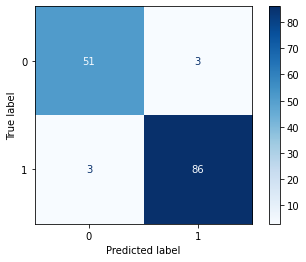

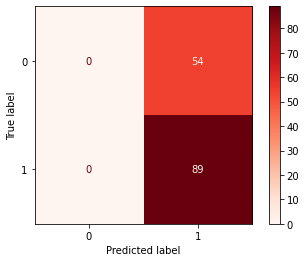

In [56]:
#Use sns.heatmap() to plot the confusion matrices from above.  
#Set annot = True to see the numbers, and change the colormap to something easier to read
#with cmap='Greens' (or whatever color map you like)
ConfusionMatrixDisplay.from_estimator(knn_pipe, X_test, y_test, cmap = 'Blues');
ConfusionMatrixDisplay.from_estimator(dummy_pipe, X_test, y_test, cmap = 'Reds');


We see the false positives predictions (top right) and false negative predictions (bottom left) that our model made.  However, the bottom left is out of 89 total and the top right is out of 54 total.  We can see the normalized ratios of true and false predictions by normalizing along the 'true' or 'pred' axes in the confusion_matrix() function.  

To normalize along the 'true' axis, we set `confusion_matrix(y_test, y_prediction, normalize = 'true')`.  

Notice that it is the string 'true' NOT the boolean value: `True`

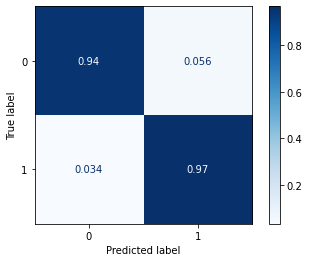

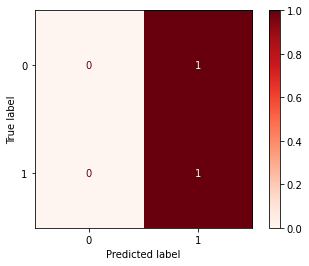

In [55]:
#Recreate the confusion matrix above, but with the values normalized along the 'true' axis.
ConfusionMatrixDisplay.from_estimator(knn_pipe, X_test, y_test, cmap = 'Blues', normalize = 'true');
ConfusionMatrixDisplay.from_estimator(dummy_pipe, X_test, y_test, cmap = 'Reds', normalize = 'true');

We can now see that our KNN model successfully classified 97% of the samples in our test set that were malignant, class 1, and 94% of the samples in our test set that were benign, class 0.

Another quick way to check the accuracy, recall, and precision of a model on a test set is with `classification_report()`, which runs several metrics on both classes simultaneously.

In [59]:
#Use classifiction_report() to print a report of several metrics for all classes at once
#for both models
knn_report = classification_report(y_test, knn_preds)
print(knn_report)

dummy_report = classification_report(y_test, dummy_preds)
print(dummy_report)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        54
           1       0.97      0.97      0.97        89

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.62      1.00      0.77        89

    accuracy                           0.62       143
   macro avg       0.31      0.50      0.38       143
weighted avg       0.39      0.62      0.48       143



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


You'll notice that each class has a different recall and precision.  f1-score, by the way, is the harmonic mean of the precision and recall.  

classification_report also tells us the averages of the precisions, means, and f1-scores.  'support' is how many samples there are of each class.

# Multi-class Metrics

Precision, recall, and accuracy also extend to cases when we have more than 2 possible classes.  However, in order to know how to calculate precision and recall we have to decide which class is our positive class.  We also become interested in the most complex patterns of errors that can occur.  

For examples, suppose we have a problem with 3 possbile classes.  We might ask: 

When our model misclassifies class 1 samples, is it more often classifying them as class 0, or class 2?  This my help us understand why it is making that kind of mistake and how we can improve performance.

This is where confusion matrices become even more useful in understanding how our model is behaving.

# Summary

Accuracy, precision, and recall all are metrics that give us different insights into how our model is performing in making predictions.  No one of them alone tells us everything, and different metrics are more or less important depending on our business problem.

However, we need to measure all three to make sure our model is making useful predictions.  Two ways to do this quickly are with a confusion matrix and a classification report.